## Walkthrough of the WZS project

This notebook will explain how to use all modules contained in this project for analysis, using the ipython notebook to allow the user to run code and test different methods for creating new LP problems.  For a general overview of the project, or for information on running automated scripts, see README.md 

The modules this document will cover are:
- rankLP.py
- emailnotice.py
- examples.dfxxx

In [1]:
%pylab inline
import pandas as pd
import re
from pulp import GLPK, PULP_CBC_CMD
import time

scriptStartTime = time.time()

Populating the interactive namespace from numpy and matplotlib


### importing rankLP module

In [2]:
import rankLP as rlp

### examples.dfxxx

The following line of code imports an already pre-processed pandas dataframe (df), corresponding to the kind of data we need for solving the LP problem we will be creating.

In [3]:
from examples.df929 import df

category [30010303] fenlei [沐浴乳 露]
Total rows (M) before preprocessing: 147


## Customize analysis

Here are some options to customize an analysis:

- preprocessing the df further

In [4]:
df = rlp.normalizeColumns(df)   ##converts all integers to a range of numbers between (0,1)
df = rlp.flipRankCols(df)       ##makes high ranks (like 1524) into low numbers, low ranks (like 7) into high numbers

- change the lower/upper bounds, pass as arguments to the forceSolution function

In [5]:
#lboundA =                       ##default .01      ##copy this: lbound_a=lboundA
uboundA = 10                      ##default 10      ##copy this: ubound_a=uboundA
lboundV = 1                      ##default .01      ##copy this: lbound_v=lboundV
uboundV = 100                      ##default 100      ##copy this: ubound_v=uboundV

### Start solving LP problems

specify solving method (add more here for whichever methods are installed)

In [6]:
solver=PULP_CBC_CMD()                      #default, comes with pulp
#solver=GLPK()

First, solve by pages and pageset.  We'll do this first since the examples.df929 dataframe contains a column "page", which we'll need to drop when solving by product.  Note that this column is not used in solving -- it's only used to understand how to define the conditions in the LP problem.  

The forceSolution() function will keep sampling from df until it finds a solution, starting with the entire product set (M products), then sampling (M-1) products, then sampling (M-2) products, and so forth until a solution is found.  These solutions will be reported on in images/Mdistributions.png

In [7]:
prob_page = rlp.forceSolution(df, by="page", solver=solver, ubound_a=uboundA, lbound_v=lboundV, ubound_v=uboundV)

##Define a custom page set here
pageset = {1:range(1,2), 2:range(2,4), 3:range(4,8)}
prob_pageset = rlp.forceSolution(df, by="pageset", solver=solver, c=pageset, ubound_a=uboundA, lbound_v=lboundV, ubound_v=uboundV)
##
##  Note: only define the first pagesets.  The tail will be captured by the rankByPageset() function

Now, solve by product, forcing product scores to monotonically decrease.

In [8]:
###remove page feature
df = df.drop("page", axis=1)

prob_prod = rlp.forceSolution(df, by="product", solver=solver, ubound_a=uboundA, lbound_v=lboundV, ubound_v=uboundV)

### Visualize the results

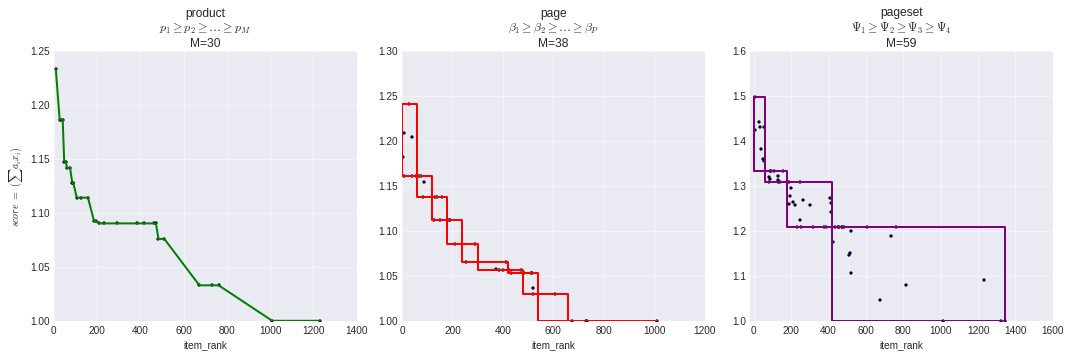

In [10]:
rlp.plotSolutions(prob_prod, prob_page, prob_pageset, pageset, lboundV)

In [20]:
df.columns

Index([                 u'q30',          u'allcomments',
                      u'rank7',               u'rank14',
                     u'rank30',               u'rank60',
               u'currentprice',                  u'c26',
                        u'c28',                  u'c30',
                        u'c34',                  u'c45',
                      u'agg02',                u'agg04',
                      u'agg07',          u'is_in_stock',
       u'positive_comment_num',   u'medium_comment_num',
       u'negative_comment_num',                u'agg17',
                      u'agg13',                u'agg14',
                      u'agg15',                u'agg16',
                      u'agg09',                u'agg10',
                      u'agg11',                u'agg12',
                  u'featagg01',            u'featagg02',
                  u'featagg03',            u'featagg04',
                  u'featagg05',            u'featagg07',
                  u'featagg08',

In [18]:
for b in prob_page.variables():
    print b,'=',b.varValue

 a__DOVE = 0.093137814
a__HAZELINE = 0.01
a__LIFEBUOY = 0.01
a__LUX = 0.01
a__LYNX = 0.01
a__agg02 = 0.32782808
a__agg04 = 0.23070912
a__agg07 = 10.0
a__agg09 = 0.01
a__agg10 = 0.01
a__agg11 = 0.01
a__agg12 = 0.01
a__agg13 = 0.46859497
a__agg14 = 0.01
a__agg15 = 0.01
a__agg16 = 0.01
a__agg17 = 0.01
a__allcomments = 0.01
a__c26 = 0.01
a__c28 = 3.7731546
a__c30 = 0.01
a__c34 = 0.01
a__c45 = 0.01
a__currentprice = 4.1624982
a__dummy1 = 0.01
a__dummy2 = 0.7922281
a__featagg01 = 2.3854288
a__featagg013 = 0.97854768
a__featagg02 = 10.0
a__featagg03 = 0.51794972
a__featagg033 = 0.01
a__featagg04 = 0.01
a__featagg043 = 0.01
a__featagg05 = 0.01
a__featagg053 = 0.01
a__featagg07 = 0.01
a__featagg073 = 0.81200148
a__featagg08 = 10.0
a__hasAttr00 = 10.0
a__hasAttr01 = 4.0781308
a__hasAttr02 = 0.01
a__hasAttr03 = 0.01
a__hasAttr04 = 7.5453661
a__hasAttr05 = 6.8833741
a__hasAttr06 = 10.0
a__is_in_stock = 9.8625245
a__medium_comment_num = 0.82278073
a__negative_comment_num = 0.40899995
a__positive_co

In [10]:
print "time to execute script: %.1f seconds" % (time.time() - scriptStartTime)

time to execute script: 50.8 seconds


If doing ad-hoc analysis, visualize the values for $a_i$, $b_i$, $c_i$, or $v_i$ of a given problem-type

In [24]:
rlp.viewAs(prob_page)
#rlp.viewBs(prob_prod)
#rlp.viewCs(prob_prod)
rlp.viewVs(prob_page)
#rlp.viewAll(prob_prod)

a__DOVE 	= 0.01
a__HAZELINE 	= 8.1363608
a__LIFEBUOY 	= 6.460859
a__LUX 	= 0.01
a__LYNX 	= 10.0
a__agg02 	= 10.0
a__agg04 	= 0.01
a__agg07 	= 5.9959182
a__agg09 	= 2.1590767
a__agg10 	= 8.3602956
a__agg11 	= 10.0
a__agg12 	= 0.01
a__agg13 	= 0.01
a__agg14 	= 0.01
a__agg15 	= 0.01
a__agg16 	= 0.01
a__agg17 	= 0.01
a__allcomments 	= 0.01
a__c26 	= 0.14306731
a__c28 	= 0.01
a__c30 	= 0.01
a__c34 	= 0.086273189
a__c45 	= 0.01
a__currentprice 	= 0.17700276
a__featagg01 	= 0.012043681
a__featagg013 	= 0.01
a__featagg02 	= 10.0
a__featagg03 	= 0.01
a__featagg033 	= 0.01
a__featagg04 	= 0.01
a__featagg043 	= 0.018421462
a__featagg05 	= 0.01
a__featagg053 	= 0.01
a__featagg07 	= 0.01
a__featagg073 	= 0.01
a__featagg08 	= 10.0
a__hasAttr00 	= 10.0
a__hasAttr01 	= 2.4850981
a__hasAttr02 	= 0.01
a__hasAttr03 	= 10.0
a__hasAttr04 	= 9.8468802
a__hasAttr05 	= 5.0428064
a__hasAttr06 	= 9.9934668
a__is_in_stock 	= 6.0165386
a__medium_comment_num 	= 0.01
a__negative_comment_num 	= 0.01
a__positive_comm

Optionally, you can pass the viewAs method a threshold to restrict those values which are _above_ the threshold.

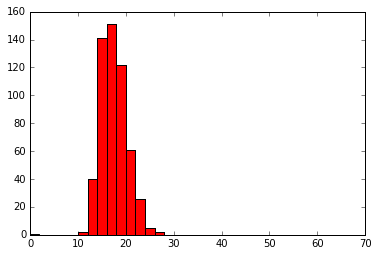

In [41]:
msg = "LP solution script finished!\n\n Counts of solutions for each product type given in bins of [0,2,4,...,68,70]\n"
for probtype in ["prod", "page","pageset"]:
    msg += "\nSolutions and important attributes for %s:\n\n" % probtype
    n, bins, plot = hist(Mprod, range=(0,70), bins=35)
    msg += str(n)+"\n\n"
    for k in sorted(importanceDict["prod"], key=importanceDict["prod"].get, reverse=True):
        msg += "%s:\t%i\n" % (k,importanceDict["prod"][k]) 

In [11]:
reload(rlp)

<module 'rankLP' from 'rankLP.py'>

In [31]:
for a in prob_prod.variables():
    print a

a__DOVE
a__HAZELINE
a__LIFEBUOY
a__LUX
a__LYNX
a__agg02
a__agg04
a__agg07
a__agg09
a__agg10
a__agg11
a__agg12
a__agg13
a__agg14
a__agg15
a__agg16
a__agg17
a__allcomments
a__c26
a__c28
a__c30
a__c34
a__c45
a__currentprice
a__dummy1
a__dummy2
a__featagg01
a__featagg013
a__featagg02
a__featagg03
a__featagg033
a__featagg04
a__featagg043
a__featagg05
a__featagg053
a__featagg07
a__featagg073
a__featagg08
a__hasAttr00
a__hasAttr01
a__hasAttr02
a__hasAttr03
a__hasAttr04
a__hasAttr05
a__hasAttr06
a__is_in_stock
a__medium_comment_num
a__negative_comment_num
a__positive_comment_num
a__q30
a__rank14
a__rank30
a__rank60
a__rank7
v_0_0009
v_0_0027
v_0_0031
v_0_0041
v_0_0048
v_0_0056
v_0_0060
v_0_0075
v_0_0085
v_0_0088
v_0_0090
v_0_0106
v_0_0127
v_0_0158
v_0_0186
v_0_0197
v_0_0209
v_0_0231
v_0_0291
v_0_0386
v_0_0416
v_0_0461
v_0_0472
v_0_0484
v_0_0511
v_0_0673
v_0_0730
v_0_0762
v_0_1010
v_0_1232


In [35]:
df.q30.index=np.arange(1,len(df.q30)+1)

In [42]:
df.q30[-5:]

65    0.004911
66    0.001857
67    0.004050
68    0.001467
69    0.000702
Name: q30, dtype: float64

In [47]:
nrows, ncols   = df.shape
rnames, cnames  = df.index, df.columns
print nrows
print ncols
print rnames
print cnames

69
54
Index([u'0004', u'0007', u'0009', u'0027', u'0031', u'0039', u'0041', u'0048',
       u'0054', u'0056', u'0060', u'0066', u'0075', u'0083', u'0084', u'0085',
       u'0088', u'0090', u'0106', u'0127', u'0129', u'0131', u'0139', u'0150',
       u'0158', u'0186', u'0189', u'0196', u'0197', u'0209', u'0221', u'0231',
       u'0247', u'0248', u'0252', u'0263', u'0291', u'0303', u'0315', u'0374',
       u'0386', u'0400', u'0410', u'0411', u'0414', u'0416', u'0426', u'0432',
       u'0450', u'0457', u'0461', u'0472', u'0474', u'0484', u'0507', u'0511',
       u'0517', u'0518', u'0521', u'0605', u'0673', u'0730', u'0735', u'0762',
       u'0813', u'1010', u'1232', u'1322', u'1346'],
      dtype='object')
Index([                 u'q30',          u'allcomments',
                      u'rank7',               u'rank14',
                     u'rank30',               u'rank60',
               u'currentprice',                  u'c26',
                        u'c28',                  u'c30',
  

In [50]:
from examples.df929 import df

In [65]:
s = df["rank7"]

In [1]:
from examples.dfsept import df, chnAttLookup


category [30010303] fenlei [沐浴乳 露]
Total rows (M) before preprocessing: 152


In [6]:
sss= "dsd"
sss.replace("s","")

'dd'

In [7]:
df.shape

(73, 58)

In [3]:
df.columns

Index([         u'q30',       u'rank14',        u'rank7',       u'rank30',
             u'rank60', u'currentprice',  u'allcomments',          u'c26',
                u'c28',          u'c30',          u'c34',          u'c45',
              u'agg02',        u'agg08',     u'is_promo',        u'agg17',
              u'agg13',        u'agg14',        u'agg15',        u'agg16',
              u'agg09',        u'agg10',        u'agg11',        u'agg12',
          u'featagg01',    u'featagg02',    u'featagg03',    u'featagg04',
          u'featagg05',    u'featagg06',    u'featagg07',    u'featagg08',
         u'featagg013',   u'featagg033',   u'featagg043',   u'featagg053',
         u'featagg063',   u'featagg073',         u'DOVE',     u'HAZELINE',
           u'LIFEBUOY',          u'LUX',         u'LYNX',    u'hasAttr00',
          u'hasAttr01',    u'hasAttr02',    u'hasAttr03',    u'hasAttr04',
          u'hasAttr05',    u'hasAttr06',    u'hasAttr07',     u'no_promo',
          u'hasAttr08',  

In [77]:
from examples.df929 import df as df2

In [79]:
df2.columns

Index([                 u'q30',          u'allcomments',
                      u'rank7',               u'rank14',
                     u'rank30',               u'rank60',
               u'currentprice',                  u'c26',
                        u'c28',                  u'c30',
                        u'c34',                  u'c45',
                      u'agg02',                u'agg04',
                      u'agg07',          u'is_in_stock',
       u'positive_comment_num',   u'medium_comment_num',
       u'negative_comment_num',                u'agg17',
                      u'agg13',                u'agg14',
                      u'agg15',                u'agg16',
                      u'agg09',                u'agg10',
                      u'agg11',                u'agg12',
                  u'featagg01',            u'featagg02',
                  u'featagg03',            u'featagg04',
                  u'featagg05',            u'featagg07',
                  u'featagg08',

In [95]:
#df = df2
df = rlp.normalizeColumns(df, normConstant=1000)
df = rlp.flipRankCols(df)

####2016-10-11 [Evan] Add a bin/int tag to columnnames
bincolumns = [col for col in df.columns if len(df[col].unique())<=3 and col!="page"]
df = df.rename(columns={name: name+"bin" for name in bincolumns})
intcolumns = [col for col in df.columns if len(df[col].unique())>3 and col!="page"]
df = df.rename(columns={name: name+"int" for name in intcolumns})

In [14]:
from examples.df929 import df as d2

category [30010303] fenlei [沐浴乳 露]
Total rows (M) before preprocessing: 147


In [1]:
from examples.dfsept import df
df.head(10)

category [30010303] fenlei [沐浴乳 露]
Total rows (M) before preprocessing: 152


,q30,rank14,rank7,rank30,rank60,currentprice,allcomments,c26,c28,c30,...,hasAttr07,hasAttr08,hasAttr09,hasAttr10,hasAttr11,hasAttr12,hasAttr13,dummy1,dummy2,page
0004,26820.000000,1.0,1.0,4.0,14.0,39.50,193961.0,580.0,580.0,580.0,...,0,0,0,1,0,0,0,0,0,1
0009,26287.500000,7.0,6.0,9.0,10.0,55.90,158817.0,363.0,363.0,363.0,...,0,0,1,0,0,0,0,0,1,1
0011,12106.142857,12.0,12.0,7.0,13.0,68.00,29773.0,994.0,1030.0,1030.0,...,1,0,0,0,0,0,0,0,1,1
0027,7317.857143,26.0,29.0,56.0,33.0,68.00,9561.0,1003.0,1181.0,1195.0,...,1,0,0,0,1,0,0,1,1,1
0031,34007.142857,37.0,32.0,31.0,56.0,45.90,92654.0,173.0,173.0,173.0,...,0,0,1,0,0,0,0,1,1,1
0037,5306.785714,38.0,38.0,60.0,127.0,47.19,5570.0,884.0,946.0,1009.0,...,0,0,1,0,0,0,0,0,1,1
0052,41553.214286,40.0,37.0,41.0,112.0,45.90,10391.0,409.0,466.0,466.0,...,0,0,1,0,0,0,0,0,0,1
0053,5607.857143,42.0,45.0,39.0,72.0,55.90,24042.0,929.0,1048.0,1137.0,...,0,0,1,0,0,0,0,0,1,1
0067,4731.428571,33.0,52.0,27.0,11.0,73.90,17702.0,1023.0,1134.0,1134.0,...,0,1,0,0,0,0,0,0,1,2
0076,2516.785714,80.0,87.0,85.0,184.0,47.20,3695.0,429.0,471.0,518.0,...,0,0,1,0,0,0,0,1,0,2


In [3]:
df.columns

Index([                 u'q30',               u'rank14',
                      u'rank7',               u'rank30',
                     u'rank60',         u'currentprice',
                u'allcomments',                  u'c26',
                        u'c28',                  u'c30',
                        u'c34',                  u'c45',
                      u'agg02',                u'agg07',
                      u'agg08',             u'is_promo',
       u'positive_comment_num',   u'medium_comment_num',
       u'negative_comment_num',                u'agg17',
                      u'agg13',                u'agg14',
                      u'agg15',                u'agg16',
                      u'agg09',                u'agg10',
                      u'agg11',                u'agg12',
                  u'featagg01',            u'featagg02',
                  u'featagg03',            u'featagg04',
                  u'featagg05',            u'featagg07',
                  u'featagg08',

In [107]:
df.reset_index().drop_duplicates(subset="index").shape

(72, 59)

In [109]:
df = df[~df.index.duplicated(keep='first')]

In [110]:
df.shape

(72, 58)

In [2]:
import rankLP as rlp
from examples.dfsept import df, chnAttLookup

####2016-10-12 [Evan] Remove columns
removeThese=["agg02","featagg08", "featagg02", u'rank7', u'rank14', u'rank60', u'c28', u'c30', u'c34', u'c45']
df = df.drop(removeThese, axis=1)

####2016-10-09 [Evan] Normalize columns (optional)
df = rlp.normalizeColumns(df, normConstant=1000)
df = rlp.flipRankCols(df)

####2016-10-11 [Evan] Add a bin/int tag to columnnames
bincolumns = [col for col in df.columns if len(df[col].unique())<=3 and col!="page"]
df = df.rename(columns={name: name+"bin" for name in bincolumns})
intcolumns = [col for col in df.columns if len(df[col].unique())>3 and col!="page"]
df = df.rename(columns={name: name+"int" for name in intcolumns})

####2016-10-13 [Evan] scale int columns by 100

#for col in df.columns:
#    if col.endswith("int"):
#        df[col] = df[col]*100
#
#### can remove after it successfully works with normalizeColumns method

####2016-10-17 [Evan] remove duplicate rows

df = df[~df.index.duplicated(keep='first')]

In [10]:
df.columns = [str(s.replace("_","")) for s in df.columns]

In [12]:
df.columns

Index([u'q30int', u'rank30int', u'currentpriceint', u'allcommentsint',
       u'c26int', u'agg08bin', u'ispromobin', u'agg17int', u'agg13int',
       u'agg14int', u'agg15int', u'agg16int', u'agg09int', u'agg10int',
       u'agg11int', u'agg12int', u'featagg01int', u'featagg03int',
       u'featagg04int', u'featagg05int', u'featagg06bin', u'featagg07bin',
       u'featagg013bin', u'featagg033int', u'featagg043int', u'featagg053int',
       u'featagg063bin', u'featagg073bin', u'DOVEbin', u'HAZELINEbin',
       u'LIFEBUOYbin', u'LUXbin', u'LYNXbin', u'hasAttr00bin', u'hasAttr01bin',
       u'hasAttr02bin', u'hasAttr03bin', u'hasAttr04bin', u'hasAttr05bin',
       u'hasAttr06bin', u'hasAttr07bin', u'nopromobin', u'hasAttr08bin',
       u'hasAttr09bin', u'hasAttr10bin', u'dummy1bin', u'dummy2bin', u'page'],
      dtype='object')